In [1]:
# python setup.py bdist_wheel
# pip install -e .


from evolution import genetic_algorithm as ga
import numpy as np
import string
from copy import copy

In [39]:
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
from collections import OrderedDict
import time

class Cache(object):
    def __init__(self,size):
        self.storage = OrderedDict()
        self.limit = size

    def add(self,key,value):
        
        current_time = time.time()

        self.storage[key] = {
            "value" : value,
            "timestamp": current_time
        }

        self.storage.move_to_end(key)
        self._enforce_size_constraint()

    def get(self,key):
        current_time = time.time()

        if key not in self.storage:
            return None
        
        self.storage[key]['timestamp'] = current_time

        item = self.storage[key]

        self.storage.move_to_end(key)

        return item["value"]
    

    def _enforce_size_constraint(self):
        """Evict the oldest accessed item if the cache exceeds the max size."""
        if len(self.storage) > self.limit:
            # Remove the first item (oldest accessed item)
            self.storage.popitem(last=False)

    def __repr__(self):
        """Display the current cache contents."""
        return str({
            key: {
                "value": meta["value"],
                "timestamp": meta["timestamp"]
            }
            for key, meta in self.storage.items()
        })

cache = Cache(size=1000)
fitness_calls = 0
total_fitness_calls = 0

class Ind(object):
    def __init__(self,copy=False,**kwargs):

        self.kwargs          = kwargs
        self._gene           = None
        self._fitness        = None  

        self.metric          = kwargs.get('metric')
        self.repr            = kwargs.get('repr')

        if not copy:
            self.generate()

    def generate(self):
        gene_type           = self.kwargs.get('gene_type')
        gene_size           = self.kwargs.get('gene_size')
        gene_upper_limit    = self.kwargs.get('gene_upper_limit')

        if gene_type == 'binary':
            self._gene = np.random.randint(2, size=gene_size)

        elif gene_type == 'integer':
            self._gene = np.random.randint(gene_upper_limit, size=gene_size)

        elif gene_type == 'real':
            self._gene = np.random.rand(gene_type)*gene_upper_limit

        else:
            raise(f"{gene_type} is not a Valid Gene Type")
        
    @property
    def fitness(self):
        if self._fitness == None:
            global total_fitness_calls
            total_fitness_calls+=1
            cached_fitness = cache.get(str(self._gene))
            if cached_fitness:
                self._fitness = cached_fitness
            else:
                global fitness_calls
                fitness_calls+=1
                self._fitness = self.metric(self._gene)
                cache.add(str(self._gene),self._fitness)
            
        return self._fitness

    @property
    def gene(self):
        if self._gene:
            return self._gene
        else:
            return "No genome Available"
    
    def mutate(self,prob = 1.0):

        if np.random.rand() < prob:

            mutation_type       = self.kwargs.get('mutation_type')
            gene_type           = self.kwargs.get('gene_type')
            gene_upper_limit    = self.kwargs.get('gene_upper_limit')

            if mutation_type == 'random range':

                mutation_range = self.kwargs.get('mutation_range')     
                mutation_range = (-1,1) if not mutation_range else mutation_range
                low,high = mutation_range

                i = np.random.randint(len(self._gene))

                if gene_type == 'real':
                    self._gene[i] += np.random.rand()*(high - low) + low
                else:
                    self._gene[i] += np.random.randint(low = low,high = high+1)
                    self._gene[i] %= (gene_upper_limit+1)
            else:
                raise(f"{mutation_type} is not a Valid Mutation Type")
            
            self._fitness = None
        
        return self
    
    def copy(self):
        c = Ind(copy=True,**self.kwargs)
        c._gene           = self._gene
        c._fitness        = self._fitness  

        return c


    def crossover(self,dad):
        crossover_type = self.kwargs.get('crossover_type')

        new_gene = []
        if crossover_type == "random mix":
            choice = np.random.randint(2, size=len(self._gene))
            
            for i,c in enumerate(choice):
                if c:
                    new_gene.append(self._gene[i])
                else:
                    new_gene.append(dad._gene[i])
        elif crossover_type == "split":

            split_size = np.random.rand()

            cut_point = int(len(self._gene)*split_size)

            new_gene.extend(dad._gene[:cut_point])
            new_gene.extend(self._gene[cut_point:])


        else:
            raise(f"{crossover_type} is not a Valid Crossover Type")

        


        child = Ind(**self.kwargs)
        child._gene = new_gene

        return child

    def __repr__(self):
        return self.repr(self._gene)
    

def _roulette(fitness_list,pop,n):

    if n <= 0:
        return []

    fitness_list = np.array(fitness_list)

    info = 1/fitness_list

    prob = np.array(info)/np.sum(info)
    sur = np.random.choice(pop, size=n, p=prob, replace=False).tolist()

    return [s.copy() for s in sur]


def run(max_gen=100,pop_size=30,prole_size=10,mutation_rate=1/30,stop=0,verbose=True,**kwargs):

    cache_size = kwargs.get("cache_size")
    if cache_size:
        cache.limit = cache_size


    global fitness_calls
    global total_fitness_calls
    fitness_list_best = []
    fitness_list_avg  = []
    fitness_calls = 0
    total_fitness_calls = 0
    pop = []

    pbar = tqdm(list(range(pop_size)))

    for i in pbar:
        pop.append(Ind(**kwargs))
        pbar.set_description(f"Loading Initial Population | Current Fitness = {pop[i].fitness:.2f}")


    pop.sort(key = lambda x: x.fitness)
    best_global = pop[0].copy()
    pbar = tqdm(list(range(max_gen)))

    for gen in pbar:
    
        fitness_list = [ind.fitness for ind in pop]
        if best_global.fitness > pop[0].fitness:
            best_global = pop[0].copy() 
            if best_global.fitness == stop:
                break
        
        best = best_global.fitness
        avg  = np.mean(fitness_list)

        fitness_list_avg.append(avg)
        fitness_list_best.append(best)
                
        pbar.set_description(f"AVG = {avg:.2e} | BEST = {best:.2e} | {best_global} |Total Calls {fitness_calls:5d} | {total_fitness_calls-fitness_calls:5d}")

        survivors = _roulette(fitness_list.copy(), pop.copy(), pop_size - prole_size)

        new_gen = [s.mutate(mutation_rate) for s in survivors]

        for _ in range(prole_size):
            parents = _roulette(fitness_list, pop, 2)
            mum = parents[0]
            dad = parents[1]
            kid = mum.crossover(dad).mutate(mutation_rate)
            new_gen.append(kid)

        new_gen.sort(key=lambda x: x.fitness)
        pop = new_gen[:pop_size]


    if verbose:
        plt.figure(figsize=(20, 6))
        plt.suptitle("Genetic Algorithm Evolution Graph", fontsize=25)

        plt.plot(fitness_list_best,'--',color="lightsteelblue",label="Best")
        plt.plot(fitness_list_avg,'--',color="lightcoral",label="Average")

        plt.xlabel("generation")
        plt.ylabel("Fitness")

        plt.legend()
        plt.show()

    return best_global

Loading Initial Population | Current Fitness = 2446.00: 100%|██████████| 1000/1000 [00:00<00:00, 1059.00it/s]
AVG = 2.06e+03 | BEST = 1.29e+03 | ³ §v~}|Rç*&HuP¹wO)­wB |Total Calls  1322 |     1:   0%|          | 2/100000 [00:00<11:30:42,  2.41it/s]
AVG = 2.06e+03 | BEST = 1.29e+03 | ³ §v~}  4:   0%|          | 2/100000 [00:00<11:30:42,  2.41it/s]
AVG = 2.03e+03 | BEST = 1.29e+03 | ³ §v~}  4:   0%|          | 3/100000 [00:01<11:26:32,  2.43it/s]
AVG = 2.03e+03 | BEST = 1.29e+03 | ³ §v~} 11:   0%|          | 3/100000 [00:01<11:26:32,  2.43it/s]
AVG = 2.01e+03 | BEST = 1.24e+03 | +³ §v~} 11:   0%|          | 4/100000 [00:01<11:23:57,  2.44it/s]
AVG = 2.01e+03 | BEST = 1.24e+03 | +³ §v~} 21:   0%|          | 4/100000 [00:01<11:23:57,  2.44it/s]
AVG = 1.99e+03 | BEST = 1.24e+03 | +³ §v~} 21:   0%|          | 5/100000 [00:02<11:21:20,  2.45it/s]
AVG = 1.99e+03 | BEST = 1.24e+03 | +³ §v~} 26:   0%|          | 5/100000 [00:02<11:21:20,  2.45it/s]
AVG = 1.92e+03 | BEST = 1.10e+

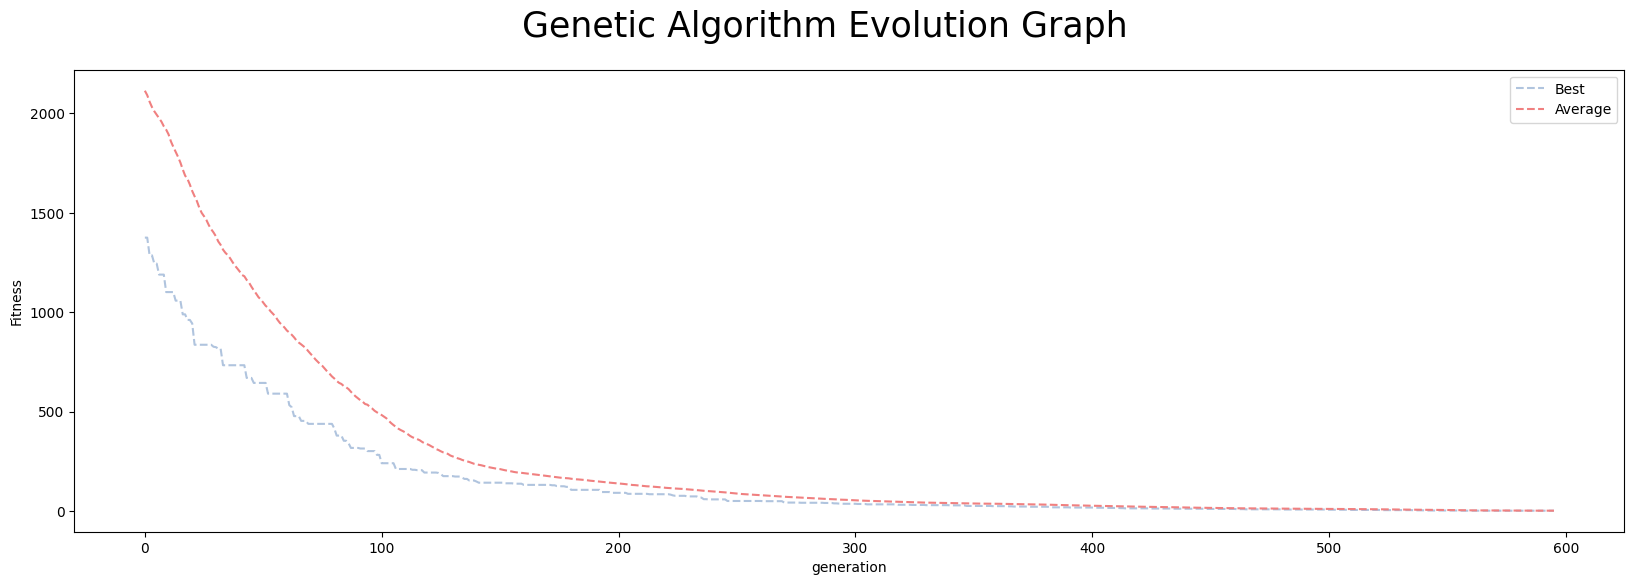

Hey, Jude, don't make it bad

In [40]:
goal = """Hey, Jude, don't make it bad"""

def dist(candidate):
    d = 0
    for i,c in enumerate(candidate):
        d+=abs(c-ord(goal[i]))
    
    return d

def decode(candidate):
    return ''.join(map(lambda c:chr(c),candidate))

def repr(candidate):
    return decode(candidate)


kwargs = {
    'metric': dist,
    'repr': repr,
    'gene_type':'integer',
    'gene_size':len(goal),
    'gene_upper_limit':255,
    'mutation_range':(-10,10),
    'mutation_type':'random range',
    'crossover_type':"split",
    'cache_size': 10000
}

run(max_gen=100000,pop_size=1000,prole_size=300,mutation_rate=3/100,**kwargs)
